In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import eden
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

/home/ikea/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarni

In [ ]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
import datetime
from graphlearn.graphlearn import Sampler as GraphLearnSampler
from eden.util import fit,estimate
from eden.path import Vectorizer
import random
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
import random
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)
 

from eden.converter.fasta import fasta_to_sequence
def get_sequences_with_names(filename='RF00005.fa'):
    sequences = fasta_to_sequence("../toolsdata/"+filename)
    return sequences


def get_graphs(fname,size):
    graphs=[g for g in get_sequences_with_names(fname)]
    random.shuffle(graphs)
    return graphs[:size]

# formerly:
#get_graphs(dataset_fname, size=100)

In [ ]:
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    '''
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1)
    sampler=rna.AbstractSampler(radius_list=[0,1],
                                thickness_list=[2], 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
    
    
    logger.info('graph grammar stats:')
    dataset_size, interface_counts, core_counts, cip_counts = sampler.grammar().size()
    logger.info('#instances:%d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (dataset_size, interface_counts, core_counts, cip_counts))
    
    
    graphs = [ b for a ,b in graphs  ]
    
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.9,
                            improving_linear_start=0.3,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=10,
                            monitor=False)
    result=[]
    for graphlist in graphs:
        result+=graphlist
    # note that this is a list [('',sequ),..]
    return result

In [ ]:
def fit_and_evaluate(pos_original, neg_original,
                     pos_sampled, neg_sampled,
                     pos_test, neg_test,
                     random_state=42):
    '''
    pos + neg orig+sampled testsets -> orig_roc , sampled_roc, augmented_roc
    '''
    
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_sampled, pos_sampled_ = tee(pos_sampled)
    neg_sampled, neg_sampled_ = tee(neg_sampled)
    
    pos_augmented = chain(pos_orig_,pos_sampled_)
    neg_augmented = chain(neg_orig_,neg_sampled_)

    predictive_performances = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),
                                     ('sample',pos_sampled,neg_sampled),
                                     ('original+sample',pos_augmented, neg_augmented)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)

        logger.info( "-"*80)
        logger.info('working on %s'%(desc))
        logger.info('training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size))

        if pos_size == 0 or neg_size == 0:
            logger.info('WARNING: empty dataset')
            predictive_performances.append(0)            
        else:
            start=time()
            pos_test,pos_test_ = tee(pos_test)
            neg_test,neg_test_ = tee(neg_test)
            
            local_estimator = fit(pos_train, neg_train, Vectorizer(4), n_jobs=-1, n_iter_search=1)
            apr, roc = estimate(pos_test_, neg_test_, local_estimator, Vectorizer(4))
            predictive_performances.append(roc)
            logger.info( 'elapsed: %.1f sec'%(time()-start))
    return predictive_performances

In [ ]:
def evaluate(pos_fname, neg_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs_pos = get_graphs(pos_fname, size=size)
    graphs_neg = get_graphs(neg_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split,random_state=random.random()*1000)
    neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split,random_state=random.random()*1000)


    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            random_state = int(313379*percentage+repetition) 
            random.seed(random_state)
            pos_train_global,pos_train_global_ = tee(pos_train_global)
            neg_train_global,neg_train_global_ = tee(neg_train_global)
            pos_test_global,pos_test_global_ = tee(pos_test_global)
            neg_test_global,neg_test_global_ = tee(neg_test_global)

            # use shuffled list to create test and sample set
            pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
            pos,pos_ = tee(pos)
            neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
            neg,neg_ = tee(neg)

            #sample independently from the 2 classes
            logger.info('Positive')
            sampled_pos = fit_sample(pos_, random_state=random_state)
            logger.info('Negative')
            sampled_neg = fit_sample(neg_, random_state=random_state)

            #evaluate the predictive performance on held out test set
            start=time()
            logger.info( "="*80)
            logger.info( 'repetition: %d/%d'%(repetition+1, n_repetitions))
            logger.info( "training percentage:"+str(percentage))
            perf_orig,\
            perf_samp,\
            perf_orig_samp = fit_and_evaluate(pos,neg,
                                              sampled_pos,sampled_neg,
                                              pos_test_global_,neg_test_global_)
            logger.info( 'Time elapsed for full repetition: %.1f sec'%((time()-start)))
            originals.append(perf_orig)
            originals_samples.append(perf_orig_samp)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        original_sample_repetitions.append(originals_samples)
        sample_repetitions.append(samples)
    
    return original_repetitions, original_sample_repetitions, sample_repetitions

In [ ]:
def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions):
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    FONTSIZE=20
    ws = 1
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    
    
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original+sample')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='original')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample')

    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.xlim(2,15)
    #plt.ylim(0.99,1.005)
    plt.ylim(0.0,1.005)
    plt.title(dataset+'\n',fontsize=20)
    plt.legend(loc='lower right',fontsize=18)
    plt.ylabel('ROC AUC',fontsize=18)
    plt.xlabel('Training set size per family',fontsize=18)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

#load("DATAS")
#plot("RF00162 vs RF00005 learning curve", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

In [ ]:
'''
def save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions):
    with open(result_fname,'w') as f:
        f.write('dataset sizes list:\n')
        for perc in percentages:
            f.write('%s '% perc)
        f.write('\n')
        f.write('AUC scores:\n')
        for repetitions in original_repetitions,original_sample_repetitions,sample_repetitions:
            f.write('%s\n' % len(repetitions))
            for repetition in repetitions:
                for auc in repetition:
                    f.write('%s ' % auc)
                f.write('\n')
    
def load_results(result_fname):
    with open(result_fname) as f:
        comment = next(f)
        line = next(f)
        percentages = [float(x) for x in line.split()]
        comment = next(f)

        original_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_repetitions.append(repetition)

        original_sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_sample_repetitions.append(repetition)


        sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            sample_repetitions.append(repetition)
            
    return percentages, original_repetitions,original_sample_repetitions,sample_repetitions
'''

#Experimental pipeline

In [ ]:
#plot("RF00162 vs RF01725", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

#print '%s_predictive_performance_of_samples.data'%dataset
#!cat "RF00162 vs RF00005 training curve_predictive_performance_of_samples.data"

In [ ]:
#percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results('%s_predictive_performance_of_samples.data'%dataset)
#plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

In [ ]:
'''
%%time
#special case: bursi

dataset='RF00162 vs RF00005 training curve'
#logging
logger = logging.getLogger()
if True:
    logger_fname = '%s_predictive_performance_of_samples.log'%dataset
else:
    logger_fname = None
configure_logging(logger,verbosity=1, filename=logger_fname)

#main 
start=time()
print( 'Working with dataset: %s' % dataset )

logger.info( 'Working with dataset: %s' % dataset )
pos_dataset_fname = 'RF00005.fa'
neg_dataset_fname = 'mixed.fa'

pos_dataset_fname = 'RF00162.fa'
neg_dataset_fname = 'RF01725.fa'

percentages=[.08,.2,.4,.6,.8,.95]
percentages=[.07,0.1,0.15,0.2]
percentages=[.07,.1]


# set size to 900 in production
original_repetitions,\
original_sample_repetitions,\
sample_repetitions = evaluate(pos_dataset_fname,
                              neg_dataset_fname,
                              size=100,
                              percentages=percentages,
                              n_repetitions=6, # ORIG = 10
                              train_test_split=0.7)
#save and display results
result_fname='%s_predictive_performance_of_samples.data'%dataset
save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions) 


percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results('%s_predictive_performance_of_samples.data'%dataset)
plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))
'''

In [ ]:
'''time
for dataset in dataset_names:
    #logging
    logger = logging.getLogger()
    if True:
        logger_fname = '%s_predictive_performance_of_samples.log'%dataset
    else:
        logger_fname = None
    configure_logging(logger,verbosity=1, filename=logger_fname)
    
    #main 
    start=time()
    print( 'Working with dataset: %s' % dataset )

    logger.info( 'Working with dataset: %s' % dataset )
    pos_dataset_fname = "RF00005.fa"
    neg_dataset_fname = 'mixed.fa

    percentages=[.05,.2,.4,.6,.8,.95]
    percentages=[.05,.2]

    original_repetitions,\
    original_sample_repetitions,\
    sample_repetitions = evaluate(pos_dataset_fname,
                                  neg_dataset_fname,
                                  size=400,
                                  percentages=percentages,
                                  n_repetitions=3,
                                  train_test_split=0.7)
    #save and display results
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions)    
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
    
    print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))
'''

In [ ]:
#display
'''
for dataset in dataset_names:
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
''' 

.

In [ ]:
from eden.converter.fasta import fasta_to_sequence
import matplotlib.pyplot as plt
# we always want a test and a train set to omou
def get_seq_tups(fname,size,sizeb):
    kram = fasta_to_sequence("../toolsdata/"+fname)
    graphs=[g for g in kram]
    random.shuffle(graphs)
    return graphs[:size],graphs[size:size+sizeb]

def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions): # note that the var names are not real anymore.
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    FONTSIZE=20
    ws = .3
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='sample')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample+orig')

    # testing to plot some dots
    global similarity_scores
    plt.plot(percentages,similarity_scores,'bo')
    
    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.xlim(5,20)
    plt.ylim(0.0,1.005)
    plt.title(dataset+'\n',fontsize=20)
    plt.legend(loc='lower right',fontsize=18)
    plt.ylabel('ROC AUC',fontsize=18)
    plt.xlabel('Training set size per family',fontsize=18)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

#load("DATAS")
#plot("RF00162 vs RF00005 learning curve", [30,70], [[.30,.30],[.20,.20]] , [[.40,.40],[.30,.30]],[[.70,.35],[.25,.25]])
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    '''
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1)
    sampler=rna.AbstractSampler(radius_list=[0,1],
                                thickness_list=[2], 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
    graphs = [ b for a ,b in graphs  ]
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.3,
                            improving_linear_start=0.2,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=2,
                            monitor=False)
    result=[]
    for graphlist in graphs:
        result+=graphlist
    # note that this is a list [('',sequ),..]
    return result


In [ ]:
from copy import deepcopy
import numpy as np
#  ok erstmal ueber alle x values, ne
size_test=20
dataset_a='RF00005.fa'
dataset_a='RF01725.fa'
dataset_b='RF00162.fa'
sizes=[7,8,9,10,11,12,13,14,15]
sizes=[7,8]
repeats=1

# calc everything
def get_results():
    li = [ get_datapoint(size) for size in sizes ]
    # transpose , should work OO 
    print 'li:',li
    return [list(i) for i in zip(*li)]

from graphlearn import sumsim
# calc for one "size", go over repeats
def get_datapoint(size):
    ra=[]
    rb=[]
    rab=[]
    similarities=[]
    global similarity_scores
    
    for rep in range(repeats):
        train_a,test_a = get_seq_tups(dataset_a,size,size_test)
        train_b,test_b = get_seq_tups(dataset_b,size,size_test)
        a,b,ab,similarity = evaluate_point(train_a,train_b,test_a,test_b)
        ra.append(a)
        rab.append(ab)
        rb.append(b)
        similarities.append(similarity)

    similarity_scores.append( (sum(similarities)/float(len(similarities))))
    return ra,rb,rab


def evaluate_point(train_a,train_b,test_a,test_b):
    res=[]
    res.append(  test(deepcopy(train_a),deepcopy(train_b),deepcopy(test_a),deepcopy(test_b)) )
    train_aa = fit_sample(train_a)
    train_bb = fit_sample(train_b)
    
    eins=sumsim.calcsimset(deepcopy(train_aa),deepcopy(train_a))   
    zwei=sumsim.calcsimset(deepcopy(train_bb),deepcopy(train_b))   
    drei = (eins+zwei)/2.0
    res.append(  test(deepcopy(train_aa),deepcopy(train_bb),deepcopy(test_a),deepcopy(test_b)) )
    res.append(  test(deepcopy(train_a)+deepcopy(train_aa),deepcopy(train_b)+train_bb,deepcopy(test_a),deepcopy(test_b)) )
    res.append(drei)
    return res



### just evaluate the stuff
from sklearn.linear_model import SGDClassifier
from eden.path import Vectorizer

def train_esti(neg,pos):
        v=Vectorizer()
        matrix=v.transform(neg+pos)
        res=SGDClassifier(shuffle=True)
        res.fit(matrix, np.asarray(  [-1]*len(neg)+[1]*len(pos)  ) )
        return res

def eva(esti,ne,po):
    v=Vectorizer()
    matrix=v.transform(ne)
    correct= sum(  [1 for res in esti.predict(matrix) if res == -1] ) 
    matrix2=v.transform(po)            
    correct+= sum(  [1 for res in esti.predict(matrix2) if res == 1] )
    return correct

def test(a,b,ta,tb):
    est=train_esti(a,b)
    correct=eva(est,ta,tb)
    return correct/float(size_test*2) # fraction correct
    

global similarity_scores
similarity_scores=[]
r=get_results()

In [ ]:
plot('somename', sizes, *r)

print similarity_scores
print sizes
print r


In [ ]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]


def sim(s1,s2):
    l = float( max(len(s1),len(s2))) 
    lp = l - float(levenshtein(s1,s2))
    return lp/l 


print 'testing sim eq', sim(s1[0],s1[0])
print 'testing sim dif', sim(s2[0],s1[0])

s1=['asdasd','asdasd','abc']
s2=['zxczxc','asdasd','abc']


def simsum(a,b,del_diag=False):
    res=0.0
    for i, ea in enumerate(a):
        for j, eb in enumerate(b):
            if del_diag and i==j:
                continue
            res+=simmilarity(ea,eb)
    return res


print 'testing simsum eq',simsum(s1,s1,True)
print 'testing simsum neq',simsum(s2,s1)

import math
def calcsimset(a,b):
    print 'calcsimset'
    ab=simsum(s1,s2,False)
    aa=simsum(a,a,False) 
    bb=simsum(b,b,False)
    print ab,aa,bb
    cc=aa*bb
    print cc
    print ab/math.sqrt(cc)

    
calcsimset(s1,s2)


In [ ]:
from graphlearn import sumsim
print sumsim.__file__
s1=['asdasd','asdasd','abc']
s2=['zxczxc','asdasd','abc']
sumsim.calcsimset(s1,s2)
sumsim.similarity_mean(s1,s2)

In [ ]:
%load_ext autoreload
s1 = [('', 'CUCUUAUUGAGAGCGGUGGAGGGACUGGCCCUGUGAAACCCGGCAACCUUCAAACGAAAUGUUUGAAACGGUGCUAAUACCUGCAAAACGAAUGUUUUGCAUAAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGACAGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGAAAGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGAAACGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'AGCUCAUCCAGAGGGGCAGAGGGAAACGGCCCGAUGAAGCCCCGGCAACCCUCCAGUCGGUACUCGUAGGUCACUGAUUAUGAUAGGGAAGGUGCCAAAUCCGUCUCACGGCGAGAUGCGUCGUGAGGAAGAUGAGGA'), ('', 'UGCUUAUCUAGAGUGGCGGAGGGAAACGGCCCUUUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAUUCCAGACAGAUGAGGA'), ('', 'UUCUUAUCAAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCUUUUGGCAAAAUCUAAGCCUGAAAGAUGAGAA'), ('', 'CUUUUAUCCAGAGAUGGCGGAGGGACAGGCCCGAAGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('', 'CUUUUAUCCAGAGAUGGCGGAGGGAAAGGCCCGAAGAAGCCCAGCAACCUCUUCGUAACGAAGAAAGGUGCCAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('', 'AGCUUAUCGAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCCAUCCCGAAUAUUCGGGAAUAGAUGAGCG')] 
s2 = [('ACEZ01000126.1/65345-65190', 'AGCUCAUCCAGAGGGGCAGAGGGAAACGGCCCGAUGAAGCCCCGGCAACCCUCCAGUCGGUACUCGUAGGUCACUGGCGACCACUUCGCGAGGCUCCCGACUAGGGAAGGUGCCAAAUCCGUCUCACGGCGAGAUGCGUCGUGAGGAAGAUGAGGA'), ('AP008934.1/1011112-1011223', 'CUCUUAUCCUGAGUGGCGGAGGGACAUGGACCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('AAVL02000036.1/100921-100817', 'CUCUUAUUAAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACGGCAACCCCCGAUUAUGAUGGAAGGUGCCCACCGGAGCAAUGCAAUAUUGAUCAAUAAGAG'), ('AE017225.1/4074580-4074471', 'CUCUUAUUGAGAGCGGUGGAGGGAAAGGCCCUGUGAAACCCGGCAACCUUCAAACGAAAUGUUUGAAACGGUGCUAAUACCUGCAAAACGAAUGUUUUGCAUAAUAAGAG'), ('ABDQ01000003.1/211832-211918', 'UGCUUAUCUAGAGUGGCGGAGGGACUGGCCCUUUGAAGCCCAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCAGACAGAUGAGGA'), ('AP006627.1/3008449-3008342', 'CUUUUAUCCAGAGAUGGCGGAGGGACAGGCCCGAAGAAGCCCAGCAACCAACACGUAACGUGUAAAGGUGCUAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('AAXV01000005.1/126573-126679', 'UUCUUAUCAAGAGAGACGGAGGGAUCGGCCCGAUGAAGUCUCAGCAACCAGCUCAAUCAGUAUGGUGCUAAUUCCUUUUGGCAAAAUCUAAGCCUGAAAGAUGAGAA'), ('AAXU02000001.1/3185191-3185093', 'AGCUUAUCGAGAAAGACUGAGGGAAGGGCCCGACGACGUCUUAGCAACCUGUAACCAAGGUGCUAAUUCCCAUCCCGAAUAUUCGGGAAUAGAUGAGCG')]


from Valium import sumsim as ss
print ss.__file__
#sumsim.calcsimset(s1,s2)
#ss.score(s1,s2)
a,b = ss.vectorize(s1,s2)
dist= ss.compdistr(a,b)
print dist
sim = ss.simset(a,b)
print 'sim',sim
print dist-sim

In [ ]:
import numpy as np
a=np.ones(4)

In [ ]:
np.sum(a)

In [ ]:
def get_datapoint(size):
    ra=[]
    rb=[]
    rab=[]
    similarities=[]
    global similarity_scores
    for rep in range(repeats):


        a,b,ab,similarity = evaluate_point(size)
        ra.append(a)
        rab.append(ab)
        rb.append(b)
        similarities.append(similarity)
        
    similarity_scores.append( 
        (sum(similarities)/float(len(similarities)))
        )
    return ra,rb,rab

In [ ]:
def evaluate_point(size):
    res=[]

    train_aa,train_a,test_a = get_trainthings(size,dataset_a)
    train_bb,train_b,test_b = get_trainthings(size,dataset_b)


    res.append(  
        test(deepcopy(train_a),deepcopy(train_b),deepcopy(test_a),deepcopy(test_b)) 
    )
    eins=sumsim.simset(deepcopy(train_aa),deepcopy(train_a))
    zwei=sumsim.simset(deepcopy(train_bb),deepcopy(train_b)) 
    drei = (eins+zwei)/2.0
    res.append(  test(deepcopy(train_aa),deepcopy(train_bb),deepcopy(test_a),deepcopy(test_b)) )
    res.append(  test(deepcopy(train_a)+deepcopy(train_aa),deepcopy(train_b)+train_bb,deepcopy(test_a),deepcopy(test_b)) )
    res.append(drei)
    return res

In [ ]:
import curve

sizes = [20, 25]
result = [[[0.95], [1.0]], [[0.975], [0.9]], [[0.95], [1.0]]]

sizes = [20, 25]
result = [[[1.0, 0.95, 1.0], [1.0, 0.975, 1.0]], [[0.775, 0.775, 0.925], [1.0, 1.0, 0.925]], [[0.975, 0.95, 0.975], [0.875, 0.975, 1.0]]]
similarity_scores = [1.0297192402202902, 1.0271841248414073]
curve.similarity_scores = similarity_scores 

result = [
            [
                [1.0, 1.0, 0.975, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 0.95, 1.0, 1.0, 1.0, 0.975, 0.975, 1.0, 0.975], 
                [0.975, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0],
                [1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [0.925, 0.95, 0.975, 1.0, 1.0, 0.975, 1.0, 1.0, 0.975], 
                [1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0], 
                [0.975, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0]], 
            [
                [0.825, 1.0, 0.9, 1.0, 0.975, 0.825, 0.725, 0.6, 1.0], 
                [0.675, 0.9, 0.775, 1.0, 0.85, 1.0, 0.8, 0.85, 0.975], 
                [1.0, 1.0, 0.975, 0.975, 0.9, 0.975, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0], 
                [1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0], 
                [0.975, 0.975, 1.0, 1.0, 0.975, 0.975, 0.975, 0.975, 1.0], 
                [1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975]], 
           [
                [0.975, 0.975, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0], 
                [1.0, 1.0, 0.95, 0.975, 0.975, 1.0, 0.95, 1.0, 1.0], 
                [1.0, 0.975, 1.0, 0.975, 1.0, 0.975, 1.0, 1.0, 1.0], 
                [0.975, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
        ]
similarity_scores = [1.0232968855718843, 1.0007455908832672, 0.99180448653574027, 0.98595714838649307, 0.9916254516732721, 0.98422063083413702, 0.98257742970417483]

result = [[[1.0, 0.975, 0.975, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0], [0.95, 1.0, 0.975, 1.0, 0.975, 1.0, 0.975, 0.975, 1.0], [1.0, 0.925, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975], [1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 0.975]], [[0.975, 0.975, 1.0, 0.825, 0.925, 0.925, 0.95, 1.0, 0.975], [1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.95, 1.0, 0.975], [1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975], [1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0], [0.975, 0.95, 0.975, 1.0, 1.0, 0.975, 0.975, 0.975, 0.975], [1.0, 1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 0.925], [1.0, 1.0, 1.0, 0.975, 1.0, 0.975, 1.0, 1.0, 0.975]], [[1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 0.85, 1.0, 1.0], [1.0, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.975, 1.0, 1.0, 0.975, 1.0, 1.0, 0.95], [1.0, 1.0, 0.825, 1.0, 1.0, 1.0, 0.975, 0.975, 1.0], [0.975, 1.0, 0.975, 0.975, 0.875, 1.0, 0.975, 1.0, 0.975], [1.0, 1.0, 1.0, 0.975, 1.0, 0.95, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]]
similarity_scores = [1.0168101311663511, 1.0150377354846287, 1.0009668568440384, 1.0013156444262343, 0.99809664727147385, 0.99622003788844737, 0.99512742871661353]

numgr=[20 ,25 ,30, 35, 40, 45, 50]

result = [[[0.99, 0.985, 0.985, 0.99, 0.99, 0.985, 0.985], [0.955, 0.985, 1.0, 0.99, 0.97, 0.975, 0.975], [0.985, 0.975, 0.95, 0.965, 0.965, 0.985, 0.96], [0.975, 0.955, 0.975, 0.995, 0.98, 0.975, 0.995], [0.99, 0.99, 0.99, 0.985, 0.98, 0.99, 0.985], [0.98, 0.965, 0.975, 0.98, 0.97, 0.985, 0.99], [0.995, 0.975, 0.98, 0.99, 0.995, 0.985, 0.995]], [[0.995, 0.985, 0.835, 0.78, 0.91, 0.965, 0.975], [0.995, 0.93, 0.985, 0.99, 0.98, 0.985, 0.98], [0.965, 0.845, 0.98, 0.95, 0.925, 0.975, 0.985], [0.975, 0.985, 0.975, 0.97, 0.955, 0.985, 0.985], [0.995, 0.99, 0.995, 0.985, 0.99, 0.98, 0.99], [0.99, 1.0, 0.985, 0.99, 0.995, 0.98, 0.995], [0.99, 0.985, 0.945, 0.945, 0.985, 0.99, 0.985]], [[0.99, 0.995, 1.0, 0.995, 0.99, 0.995, 1.0], [1.0, 0.98, 0.975, 0.945, 0.99, 1.0, 0.98], [0.985, 0.985, 0.975, 0.995, 0.98, 0.975, 0.97], [0.995, 0.985, 0.985, 0.985, 0.98, 0.975, 0.975], [0.985, 0.995, 0.985, 0.995, 0.995, 0.995, 0.98], [0.985, 0.995, 0.995, 0.99, 0.98, 0.99, 0.995], [0.995, 0.99, 0.995, 0.99, 0.995, 0.98, 0.985]]]
similarity_scores = [1.009134975438486, 1.0020476673182956, 0.99512728715033838, 0.9902838600590177, 0.98878387701645598, 0.98004841660025499, 0.97223030477865113]

curve.similarity_scores=similarity_scores
curve.plot("%s vs %s discriminative performance" % (curve.dataset_a[:-3],curve.dataset_b[:-3]),numgr,*result)

In [ ]:
l=np.array(range(4))
l.tolist()*7

/home/ikea/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


. k [ 0.0443629   0.32738144  0.80030082  0.18683276  0.17653465  0.72132509
  0.10689771  0.09973688  0.11484122  0.07831989  0.75110302  0.85493524
  0.10236151  0.06671896  0.06108424  0.05318691  0.18290676  0.06248424
  0.2307442   0.06805646  0.46870439  0.14099067  0.78874497  0.45324056
  0.18515714  0.16364589  0.6900455   0.14484918  0.13691777  0.56736255
  0.41750974  0.10341451  0.70801311  0.73601176]
k [ 0.05159334  0.05368092  0.08238888  0.07573681  0.2439573   0.77715203
  0.18849626  0.1401582   0.74672336  0.0942311   0.2417722   0.07492825
  0.80357484  0.0640926   0.82464191  0.16081312  0.09680532  0.0427042
  0.7447316   0.0621928   0.76950495  0.08569051  0.298003    0.22048796
  0.76610386  0.30822068  0.71626188  0.72844452  0.30930807  0.12317854
  0.10662314  0.39622649  0.63096642  0.17448032  0.6681357   0.76647985]
k [ 0.20197516  0.24125152  0.39624697  0.38373754  0.38955718  0.24750676
  0.64125622  0.6411006   0.16140893  0.26992794  0.23126367  0.16

/home/ikea/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


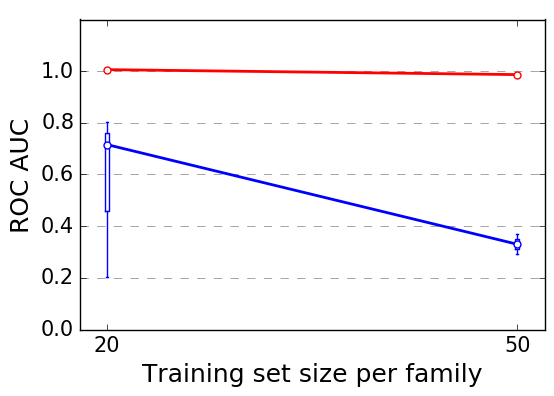

In [2]:

import oneclasscurve  as occ
sizes=[20,50]
a,b = occ.get_results(repeats=3,sizes=sizes,njobs=3,argparam=-2)
occ.plot('123',sizes,a,b)




In [ ]:

import oneclasscurve  as occ
occ.plot('123',sizes,a,b)

In [ ]:
 print a

In [ ]:
import numpy as np
a=np.array([[ 0.09634476 , 0.90365524],
 [ 0.06088005,  0.93911995],
 [ 0.07065094 , 0.92934906],
 [ 0.04671271,  0.95328729],
 [ 0.02970209 , 0.97029791],
 [ 0.29515478 , 0.70484522],
 [ 0.86338974 , 0.13661026],
 [ 0.80168559 , 0.19831441],
 [ 0.80968646 , 0.19031354],
 [ 0.12463197  ,0.87536803],
 [ 0.1517372   ,0.8482628 ],
 [ 0.34249768,  0.65750232],
 [ 0.07255634,  0.92744366],
 [ 0.02922214,  0.97077786],
 [ 0.77822639,  0.22177361],
 [ 0.81886221,  0.18113779],
 [ 0.16694517,  0.83305483],
 [ 0.12744298,  0.87255702],
 [ 0.09078483,  0.90921517],
 [ 0.04598973,  0.95401027],
 [ 0.80762083 , 0.19237917],
 [ 0.03582149 , 0.96417851],
 [ 0.82493818  ,0.17506182],
 [ 0.07749642 , 0.92250358],
 [ 0.52502072 , 0.47497928],
 [ 0.20059041 , 0.79940959],
 [ 0.54677554  ,0.45322446],
 [ 0.75185612  ,0.24814388],
 [ 0.72276445 , 0.27723555],
 [ 0.78464842 , 0.21535158],
 [ 0.41365199 , 0.58634801],
 [ 0.09839525 , 0.90160475],
 [ 0.03955736  ,0.96044264],
 [ 0.39204652  ,0.60795348],
 [ 0.58669915  ,0.41330085],
 [ 0.09951188  ,0.90048812],
 [ 0.69697943  ,0.30302057],
 [ 0.7775214   ,0.2224786 ]])

print a[:,0]
